In [1]:
# 1) INSTALLATIONS
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -q scikit-learn matplotlib tqdm timm

mouting the dataset from gdrive:

In [2]:
# 2) MOUNT DRIVE & SETUP
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


imports:

In [3]:
import os
import time
import copy
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F

paths and device used(gpu)

In [4]:
# 3) PATHS & DEVICE
DATA_DIR = '/content/drive/MyDrive/Blood_Cell_Project/images'
TRAIN_DIR = os.path.join(DATA_DIR, 'TRAIN')
TEST_DIR = os.path.join(DATA_DIR, 'TEST')
MODEL_PATH = os.path.join(DATA_DIR, 'best_efficientnet_b4.pth')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


hyperparameters set for the model

In [5]:
# 4) IMPROVED HYPERPARAMETERS
num_epochs = 35
batch_size = 24  # Reduced for larger model
image_size = 384  # EfficientNet-B4 optimal size
lr = 1e-4  # Slightly higher initial LR
weight_decay = 2e-5
patience = 8
min_lr = 1e-7

transformations

In [6]:
# 5) ENHANCED TRANSFORMS
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

creating a validation dataset and loading the dataset

In [7]:
# 6) CREATE DATASETS WITH BETTER SPLIT
train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
test_ds = datasets.ImageFolder(TEST_DIR, transform=val_test_transforms)

# 15% validation split for better evaluation
val_split = 0.15
num_train = len(train_ds)
indices = list(range(num_train))
split = int(np.floor(val_split * num_train))
np.random.seed(42)
np.random.shuffle(indices)
train_idx, val_idx = indices[split:], indices[:split]

train_ds_sub = Subset(train_ds, train_idx)
val_ds = Subset(train_ds, val_idx)

train_loader = DataLoader(train_ds_sub, batch_size=batch_size, shuffle=True,
                          num_workers=2, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                        num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                         num_workers=2, pin_memory=True)

class_names = train_ds.classes
num_classes = len(class_names)
print("Classes:", class_names)
print(f"Train: {len(train_ds_sub)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

Classes: ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
Train: 8464, Val: 1493, Test: 2487


label smoothing loss:

In [8]:
# 7) LABEL SMOOTHING LOSS (Better than standard CE)
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon=0.1, weight=None):
        super().__init__()
        self.epsilon = epsilon
        self.weight = weight

    def forward(self, preds, target):
        n_class = preds.size(1)
        log_preds = F.log_softmax(preds, dim=1)

        # One-hot with smoothing
        with torch.no_grad():
            true_dist = torch.zeros_like(log_preds)
            true_dist.fill_(self.epsilon / (n_class - 1))
            true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.epsilon)

        if self.weight is not None:
            true_dist = true_dist * self.weight.unsqueeze(0)

        return torch.mean(torch.sum(-true_dist * log_preds, dim=1))

model declaration:

In [9]:
# 8) MODEL WITH BETTER INITIALIZATION
model = models.efficientnet_b4(weights="IMAGENET1K_V1")

# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

# Enhanced classifier with dropout
in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.4),
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(512, num_classes)
)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth


100%|██████████| 74.5M/74.5M [00:00<00:00, 203MB/s]


class weights to strengthend and weaken them:

In [10]:
# 9) IMPROVED CLASS WEIGHTS (Based on your dataset)
class_weights = torch.tensor([2.0, 1.0, 3.5, 0.6], dtype=torch.float).to(device)
criterion = LabelSmoothingCrossEntropy(epsilon=0.1, weight=class_weights)

train the model?

In [11]:
# 10) TRAINING CONFIGURATION
TRAIN_MODEL = False

training of the model:

In [12]:

if TRAIN_MODEL:
    # AdamW with better settings
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay,
                     betas=(0.9, 0.999))

    # Cosine annealing with warm restarts
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=5, T_mult=2, eta_min=min_lr
    )

    scaler = torch.cuda.amp.GradScaler()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = float('inf')
    epochs_no_improve = 0

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.2e}")

        # ========== TRAINING ==========
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc="Train", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()

            # Gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            scaler.step(optimizer)
            scaler.update()

            preds = outputs.argmax(dim=1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += (preds == labels).sum().item()
            total += inputs.size(0)

        epoch_loss = running_loss / total
        epoch_acc = running_corrects / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        # ========== VALIDATION ==========
        model.eval()
        val_running_loss = 0
        val_running_corrects = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                preds = outputs.argmax(dim=1)
                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += (preds == labels).sum().item()
                val_total += inputs.size(0)

        val_loss = val_running_loss / val_total
        val_acc = val_running_corrects / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        scheduler.step()

        print(f"Train - Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")
        print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        # Save best model based on validation accuracy AND loss
        if val_acc > best_acc or (val_acc == best_acc and val_loss < best_loss):
            best_acc = val_acc
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, MODEL_PATH)
            epochs_no_improve = 0
            print(f"✓ Saved new best model (Acc: {best_acc:.4f}, Loss: {best_loss:.4f})")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                break

    # Load best model
    model.load_state_dict(best_model_wts)
    print("\nTraining complete!")

    # Plot training history
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_title('Training History - Loss')

    ax2.plot(train_accs, label='Train Acc')
    ax2.plot(val_accs, label='Val Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.set_title('Training History - Accuracy')
    plt.tight_layout()
    plt.show()

# # ========== ENHANCED TTA TESTING ==========
# import torchvision.transforms.functional as TF

# tta_transforms = [
#     lambda x: x,
#     lambda x: TF.hflip(x),
#     lambda x: TF.vflip(x),
#     lambda x: TF.rotate(x, 90),
#     lambda x: TF.rotate(x, 180),
#     lambda x: TF.rotate(x, 270),
#     lambda x: TF.hflip(TF.rotate(x, 90)),
#     lambda x: TF.vflip(TF.rotate(x, 90)),
#     lambda x: TF.hflip(TF.rotate(x, 180)),
# ]

# print("\n" + "="*50)
# print("TESTING WITH ENHANCED TTA")
# print("="*50)

# model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
# model.eval()

# all_preds, all_labels = [], []

# with torch.no_grad():
#     for inputs, labels in tqdm(test_loader, desc="Testing"):
#         inputs, labels = inputs.to(device), labels.to(device)
#         batch_preds = []

#         for t in tta_transforms:
#             t_inputs = torch.stack([t(img) for img in inputs]).to(device)
#             with torch.cuda.amp.autocast():
#                 outputs = model(t_inputs)
#             batch_preds.append(torch.softmax(outputs, dim=1))

#         preds = torch.stack(batch_preds).mean(0).argmax(dim=1)
#         all_preds.extend(preds.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())

# # Results
# print("\n" + "="*50)
# print("CLASSIFICATION REPORT")
# print("="*50)
# print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

# # Confusion Matrix
# cm = confusion_matrix(all_labels, all_preds)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names,
#             yticklabels=class_names, cmap='Blues', cbar_kws={'label': 'Count'})
# plt.xlabel('Predicted', fontsize=12)
# plt.ylabel('True', fontsize=12)
# plt.title('Confusion Matrix (Enhanced TTA)', fontsize=14)
# plt.tight_layout()
# plt.show()

# # Per-class accuracy
# print("\nPer-Class Accuracy:")
# for i, class_name in enumerate(class_names):
#     class_acc = cm[i, i] / cm[i].sum() * 100
#     print(f"{class_name}: {class_acc:.2f}%")

# test_acc = np.trace(cm) / np.sum(cm) * 100
# print(f"\nOverall Test Accuracy: {test_acc:.2f}%")

testing of the model:


RUNNING TEST SET ONLY


Testing: 100%|██████████| 104/104 [07:03<00:00,  4.07s/it]



CLASSIFICATION REPORT
              precision    recall  f1-score   support

  EOSINOPHIL     0.9354    0.8828    0.9083       623
  LYMPHOCYTE     1.0000    1.0000    1.0000       620
    MONOCYTE     1.0000    0.7500    0.8571       620
  NEUTROPHIL     0.7199    0.9391    0.8150       624

    accuracy                         0.8930      2487
   macro avg     0.9138    0.8930    0.8951      2487
weighted avg     0.9135    0.8930    0.8950      2487



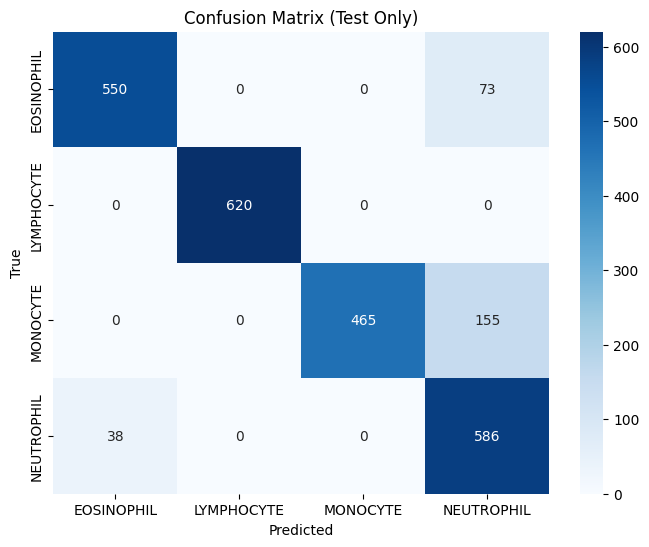


Per-Class Accuracy:
EOSINOPHIL: 88.28%
LYMPHOCYTE: 100.00%
MONOCYTE: 75.00%
NEUTROPHIL: 93.91%

Overall Test Accuracy: 89.30%


In [13]:
# ============================================
# TEST ONLY (Using saved model + TTA)
# ============================================

import torchvision.transforms.functional as TF

# ---- Define TTA transforms again (must be redefined) ----
tta_transforms = [
    lambda x: x,
    lambda x: TF.hflip(x),
    lambda x: TF.vflip(x),
    lambda x: TF.rotate(x, 90),
    lambda x: TF.rotate(x, 180),
    lambda x: TF.rotate(x, 270),
    lambda x: TF.hflip(TF.rotate(x, 90)),
    lambda x: TF.vflip(TF.rotate(x, 90)),
    lambda x: TF.hflip(TF.rotate(x, 180)),
]

print("\n" + "="*50)
print("RUNNING TEST SET ONLY")
print("="*50)

# ---- Load trained model weights ----
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model = model.to(device)
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs, labels = inputs.to(device), labels.to(device)

        batch_preds = []

        # --- TTA Predictions ---
        for t in tta_transforms:
            t_inputs = torch.stack([t(img) for img in inputs]).to(device)
            with torch.amp.autocast("cuda"):
                outputs = model(t_inputs)
            batch_preds.append(torch.softmax(outputs, dim=1))

        # Average predictions
        preds = torch.stack(batch_preds).mean(0).argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ---- Print final results ----
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

# ---- Confusion Matrix ----
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test Only)")
plt.show()

# ---- Per-class accuracy ----
print("\nPer-Class Accuracy:")
for i, cls in enumerate(class_names):
    acc = cm[i, i] / cm[i].sum() * 100
    print(f"{cls}: {acc:.2f}%")

overall_acc = np.trace(cm) / cm.sum() * 100
print(f"\nOverall Test Accuracy: {overall_acc:.2f}%")
